### Model Governance Notebook for models with and without the GLLD feature - OOT Feb
with and without `giact_last_link_date`

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import scale_scores
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
with open('../../models/customer_risk_target_from_gitlab.pkl', 'rb') as f:
    model_w_glld = pickle.load(f)
    
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model_wo_glld = pickle.load(f)

### Data Processing

In [3]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 'giact_time_since_last_link', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

## OOT Data
---

In [4]:
modeling_df = pd.read_feather('../../artifacts/oot_unscored_2020-02-17.feather')

# how thomas did it..
# date = '2020-02-17'
# modeling_df = pd.read_feather('../../artifacts/sampled_df_raw_labeled_20200623.feather')
# modeling_df = modeling_df[modeling_df['sample_date'] == pd.to_datetime(date)]
# modeling_df['age_money_account'] = (modeling_df['sample_date'] - modeling_df['date_account_opened']).dt.days
modeling_df = preprocess(modeling_df)

# OOT
modeling_df['pred_wo_glld'] = model_wo_glld.predict_proba(modeling_df[model_wo_glld.feature_name_])[:, 1]
modeling_df['score_wo_glld'] = scale_scores(modeling_df['pred_wo_glld'])

modeling_df['pred_w_glld'] = model_w_glld.predict_proba(modeling_df[model_w_glld.feature_name_])[:, 1]
modeling_df['score_w_glld'] = scale_scores(modeling_df['pred_w_glld'])

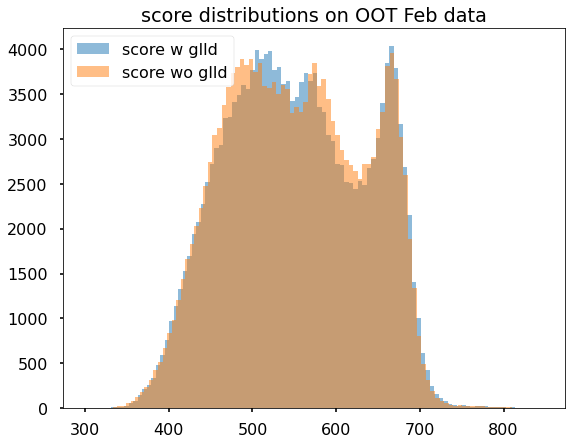

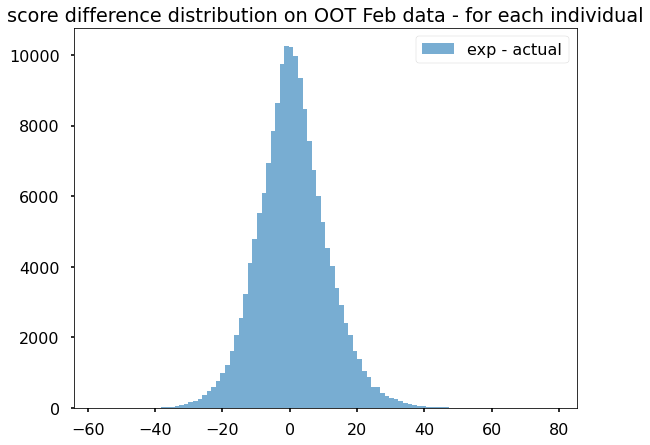

In [5]:
score_dist_plot = plot_score_dist(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, 
                                  bins=100, 
                                  dev_label='score w glld',
                                  prod_label='score wo glld',
                                  title='score distributions on OOT Feb data')
score_diff_plot = plot_difference(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, bins=100, 
                                  title='score difference distribution on OOT Feb data - for each individual')

In [6]:
score_diff_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-feb/oot_score_diff_plot.png')
score_dist_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-feb/oot_score_dist_plot.png')

### Risk Groups

In [7]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

modeling_df['risk_group_w_glld'] = get_risk_groups(modeling_df.score_w_glld)
modeling_df['risk_group_wo_glld'] = get_risk_groups(modeling_df.score_wo_glld)

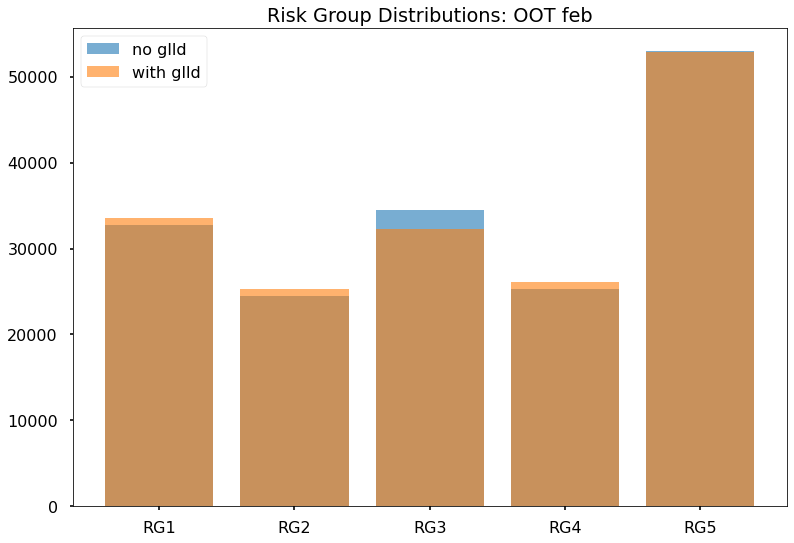

In [8]:
fig = plt.figure()
data = modeling_df.risk_group_w_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='no glld')
data = modeling_df.risk_group_wo_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='with glld')
plt.title('Risk Group Distributions: OOT feb')
plt.legend()
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-feb/oot_risk_group_distr.png')

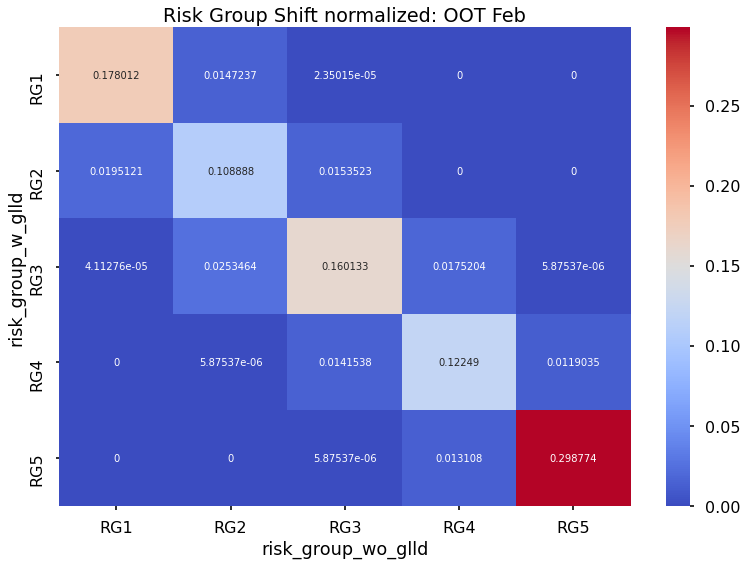

In [9]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift normalized: OOT Feb')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-feb/oot_RG_shift_norm.png')

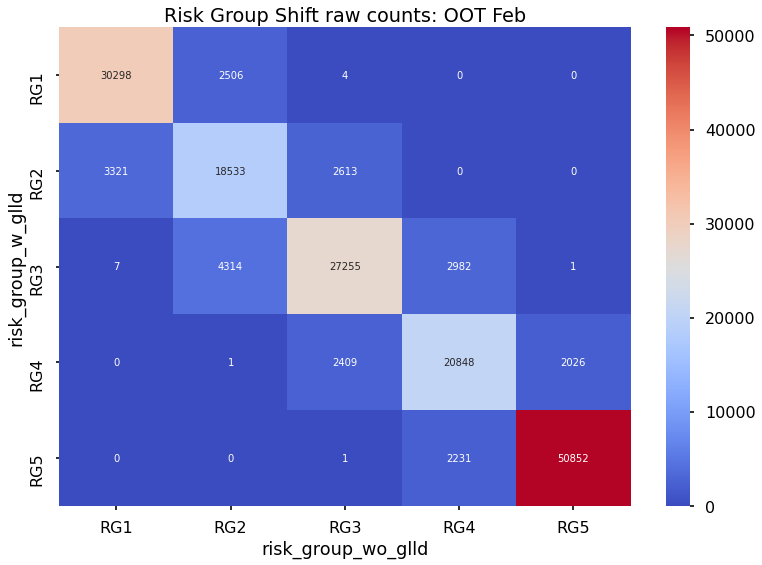

In [10]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts().sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift raw counts: OOT Feb')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-feb/oot_RG_shift_raw.png')

### Statistic Tables

In [11]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
import gc

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'fraud_score_2 alone: {auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'fico alone: {auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'model perf: {auc}, {ap}')

#### OOT Stats

In [12]:
df_ = modeling_df[(modeling_df.nr_transactions_next_90d > 0) & (modeling_df.nr_past_transactions > 0)]
get_metrics(df_, 'pred_w_glld')

fraud_score_2 alone: 73.41, 4.79
fico alone: 70.42, 12.51
model perf: 95.75, 58.44


In [13]:
get_metrics(df_, 'pred_wo_glld')

fraud_score_2 alone: 73.41, 4.79
fico alone: 70.42, 12.51
model perf: 95.69, 57.46


#### OOT Tables

In [14]:
table = build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,90.0,0.75,9.52,57.45,17021,972,720,16049,152462
1,91.0,0.77,8.54,54.85,15319,928,764,14391,154120
2,92.0,0.78,7.56,51.95,13617,879,813,12738,155773
3,93.0,0.79,6.57,49.70,11915,841,851,11074,157437
4,94.0,0.81,5.59,47.04,10213,796,896,9417,159094
5,95.0,0.82,4.61,43.91,8511,743,949,7768,160743
6,96.0,0.84,3.63,40.84,6809,691,1001,6118,162393
7,97.0,0.85,2.65,38.06,5107,644,1048,4463,164048
8,98.0,0.87,1.67,34.63,3405,586,1106,2819,165692
9,99.0,0.90,0.73,28.13,1703,476,1216,1227,167284


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.75,9.52,57.45,17021,972,720,16049,152462
91.0,0.77,8.54,54.85,15319,928,764,14391,154120
92.0,0.78,7.56,51.95,13617,879,813,12738,155773
93.0,0.79,6.57,49.7,11915,841,851,11074,157437
94.0,0.81,5.59,47.04,10213,796,896,9417,159094
95.0,0.82,4.61,43.91,8511,743,949,7768,160743
96.0,0.84,3.63,40.84,6809,691,1001,6118,162393
97.0,0.85,2.65,38.06,5107,644,1048,4463,164048
98.0,0.87,1.67,34.63,3405,586,1106,2819,165692
99.0,0.9,0.73,28.13,1703,476,1216,1227,167284



In [15]:
table = build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,170203,1692,0,168511,0
1,10.0,0.00,89.90,99.65,153182,1686,6,151496,17015
2,20.0,0.01,79.81,98.88,136162,1673,19,134489,34022
3,30.0,0.01,69.72,98.23,119142,1662,30,117480,51031
4,40.0,0.03,59.63,97.16,102122,1644,48,100478,68033
5,50.0,0.07,49.55,95.27,85102,1612,80,83490,85021
6,60.0,0.14,39.47,93.14,68081,1576,116,66505,102006
7,70.0,0.29,29.41,88.48,51061,1497,195,49564,118947
8,80.0,0.55,19.42,77.54,34041,1312,380,32729,135782
9,90.0,0.75,9.52,57.45,17021,972,720,16049,152462


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,170203,1692,0,168511,0
10.0,0.0,89.9,99.65,153182,1686,6,151496,17015
20.0,0.01,79.81,98.88,136162,1673,19,134489,34022
30.0,0.01,69.72,98.23,119142,1662,30,117480,51031
40.0,0.03,59.63,97.16,102122,1644,48,100478,68033
50.0,0.07,49.55,95.27,85102,1612,80,83490,85021
60.0,0.14,39.47,93.14,68081,1576,116,66505,102006
70.0,0.29,29.41,88.48,51061,1497,195,49564,118947
80.0,0.55,19.42,77.54,34041,1312,380,32729,135782
90.0,0.75,9.52,57.45,17021,972,720,16049,152462



In [16]:
table = build_table1(modeling_df, np.linspace(0, 99, 100), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,170203,1692,0,168511,0
1,1.0,0.00,98.99,100.00,168500,1692,0,166808,1703
2,2.0,0.00,97.98,99.94,166798,1691,1,165107,3404
3,3.0,0.00,96.97,99.94,165096,1691,1,163405,5106
4,4.0,0.00,95.96,99.88,163394,1690,2,161704,6807
...,...,...,...,...,...,...,...,...,...
95,95.0,0.82,4.61,43.91,8511,743,949,7768,160743
96,96.0,0.84,3.63,40.84,6809,691,1001,6118,162393
97,97.0,0.85,2.65,38.06,5107,644,1048,4463,164048
98,98.0,0.87,1.67,34.63,3405,586,1106,2819,165692


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,170203,1692,0,168511,0
1.0,0.0,98.99,100.0,168500,1692,0,166808,1703
2.0,0.0,97.98,99.94,166798,1691,1,165107,3404
3.0,0.0,96.97,99.94,165096,1691,1,163405,5106
4.0,0.0,95.96,99.88,163394,1690,2,161704,6807
5.0,0.0,94.95,99.82,161692,1689,3,160003,8508
6.0,0.0,93.94,99.82,159990,1689,3,158301,10210
7.0,0.0,92.93,99.76,158288,1688,4,156600,11911
8.0,0.0,91.92,99.65,156586,1686,6,154900,13611
9.0,0.0,90.91,99.65,154884,1686,6,153198,15313
10.0,0.0,89.9,99.65,153182,1686,6,151496,17015
11.0,0.0,88.89,99.53,151480,1684,8,149796,18715
12.0,0.0,87.89,99.35,149778,1681,11,148097,20414
13.0,0.0,86.88,99.35,148076,1681,11,146395,22116
14.0,0.0,85.87,99.23,146374,1679,13,144695,23816
15.0,0.0,84.86,99.23,144672,1679,13,142993,25518
16.0,0.0,83.85,99.11,142970,1677,15,141293,27218
17.0,0.0,82.84,99.05

### Build Excel Tables

In [17]:
def build_table_3(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ cumulative """
    df = []
    for (fthresh, pctl), (mthresh, pctl) in zip([(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles], [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([pctl, fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

def build_table_4(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ interval """
    df = []
    
    fpctls = [(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles]
    mpctls = [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]
    
    for i in range(0, len(fpctls) - 1):
        plo = fpctls[i][-1]
        phi = fpctls[i+1][-1]
        
        mbr = modeling_df[modeling_df[pred_col_name].between(mpctls[i+1][0], mpctls[i][0])]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name].between(fpctls[i][0], fpctls[i+1][0])]['target'].mean() * 100

        df.append([f'{plo}-{phi}', fpctls[i][0], mpctls[i+1][0], fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_5(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds cumulative """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for fthresh, mthresh in zip(fico_thresholds, model_thresholds):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_6(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds interval """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for i in range(0, len(fico_thresholds) - 1):
        mbr = modeling_df[modeling_df[pred_col_name].between(model_thresholds[i+1], model_thresholds[i], inclusive=True)]['target'].mean() * 100
        
        fbr = modeling_df[modeling_df[fico_col_name].between(fico_thresholds[i], fico_thresholds[i+1], inclusive=True)]['target'].mean() * 100

        df.append([f'{fico_thresholds[i]}-{fico_thresholds[i+1]}', f'{model_thresholds[i+1]}-{model_thresholds[i]}', fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

### Verify - model with glld

In [18]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,845.78,14.98,100.0
96.0,482.0,641.16,17.21,35.29
92.0,555.0,607.51,15.58,20.46
88.0,585.0,582.84,12.15,14.43
84.0,608.0,564.22,10.19,11.08
80.0,633.0,549.58,8.45,9.02
76.0,656.0,538.05,7.19,7.56
72.0,674.0,528.39,6.27,6.55
68.0,690.0,520.01,5.54,5.75
64.0,705.0,512.49,4.94,5.13
60.0,717.0,505.61,4.48,4.64
56.0,727.0,499.22,4.1,4.24
52.0,736.0,492.72,3.78,3.9
48.0,745.0,486.5,3.48,3.6
44.0,752.0,480.67,3.27,3.35
40.0,759.0,475.05,3.08,3.13
36.0,766.0,469.4,2.88,2.94
32.0,773.0,463.89,2.71,2.78
28.0,780.0,457.91,2.58,2.63
24.0,787.0,451.93,2.46,2.49
20.0,794.0,445.65,2.34,2.37
16.0,801.0,438.48,2.23,2.26
12.0,809.0,430.21,2.14,2.16
8.0,819.0,420.11,2.05,2.07
4.0,830.0,405.89,1.98,1.98
0.0,850.0,309.39,1.91,1.91

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,641.16,17.21,35.29
4.0-8.0,482.0,607.51,13.86,5.6

In [19]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,842.81,14.98,100.0
96.0,482.0,641.67,17.21,34.55
92.0,555.0,608.11,15.58,20.48
88.0,585.0,583.37,12.15,14.4
84.0,608.0,563.8,10.19,11.12
80.0,633.0,549.51,8.45,9.01
76.0,656.0,538.0,7.19,7.57
72.0,674.0,528.09,6.27,6.55
68.0,690.0,519.35,5.54,5.75
64.0,705.0,511.22,4.94,5.14
60.0,717.0,504.3,4.48,4.64
56.0,727.0,497.54,4.1,4.23
52.0,736.0,491.6,3.78,3.89
48.0,745.0,485.77,3.48,3.6
44.0,752.0,480.15,3.27,3.35
40.0,759.0,474.78,3.08,3.13
36.0,766.0,469.47,2.88,2.94
32.0,773.0,464.07,2.71,2.77
28.0,780.0,458.41,2.58,2.62
24.0,787.0,452.58,2.46,2.49
20.0,794.0,446.34,2.34,2.37
16.0,801.0,439.26,2.23,2.26
12.0,809.0,431.04,2.14,2.16
8.0,819.0,421.05,2.05,2.07
4.0,830.0,406.7,1.98,1.98
0.0,850.0,300.4,1.91,1.91

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,641.67,17.21,34.55
4.0-8.0,482.0,608.11,13.86,6.41
8.